# Time Series Analysis, Time Series Forecasting, and Neural Networks

This notebook provides a comprehensive introduction to time series analysis and forecasting. We will cover the following topics:

1.  **Stationarity in Time Series**
    * What is Stationarity?
    * Visual Indicators of Stationarity
    * Statistical Tests of Stationarity (Augmented Dickey-Fuller Test)
2.  **Forecasting Techniques**
    * Exponential Smoothing (Simple, Double, and Triple)
    * ARIMA
    * SARIMA
    * LSTM Neural Networks
3.  **Model Comparison**
4.  **Saving Predictions**

## 1. Stationarity in Time Series

### What is Stationarity?

A time series is said to be **stationary** if its statistical properties such as mean, variance, and autocorrelation are constant over time. Most time series models require the data to be stationary. If the time series is not stationary, we need to transform it to a stationary series before we can apply the models.

A stationary time series has the following properties:

* **Constant Mean:** The mean of the series is constant over time.
* **Constant Variance:** The variance of the series is constant over time.
* **Constant Autocorrelation:** The autocorrelation of the series is constant over time.

### Visual Indicators of Stationarity

We can visually inspect a time series plot to get an idea of whether it is stationary or not. Here are some visual cues:

* The mean of the series should be constant. If there is a trend (upward or downward), the mean is not constant, and the series is not stationary.
* The variance of the series should be constant. If the spread of the data changes over time, the variance is not constant, and the series is not stationary.
* There should be no seasonal patterns.

Let's load our data and visualize it to check for stationarity.

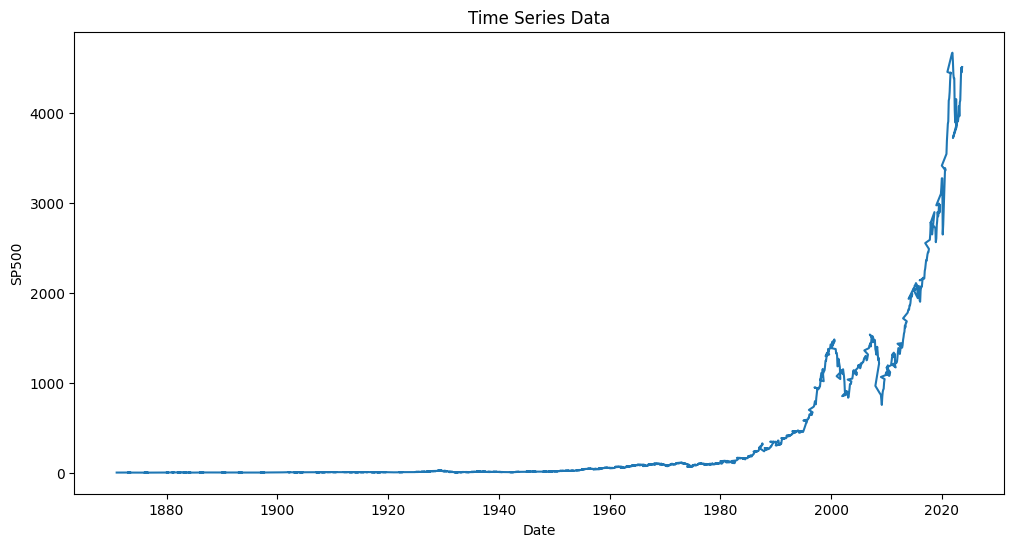

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For suppressing warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
# Make sure to upload your SP500Index.csv file to the Colab environment
url = 'https://github.com/course-files/TimeSeriesForecastingandNeuralNetworks/raw/refs/heads/main/data/SP500Index.csv'
df = pd.read_csv(url)

# Corrected the column name from 'Value' to 'SP500'
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
time_series = df['SP500']

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(time_series)
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('SP500')
plt.show()

### Decomposing Time Series
Decomposing a time series helps us understand its components: trend, seasonality, and residuals (or irregular component). This can provide insights into the underlying patterns in the data.
We can use the `seasonal_decompose` function from `statsmodels` to decompose the time series. The decomposition can be either additive or multiplicative.
- **Additive Decomposition:** The time series is expressed as the sum of its components: `Y(t) = Trend(t) + Seasonality(t) + Residual(t)`
- **Multiplicative Decomposition:** The time series is expressed as the product of its components: `Y(t) = Trend(t) * Seasonality(t) * Residual(t)`
- **Trend:** The long-term movement in the data.
- **Seasonality:** The repeating short-term cycle in the data.
- **Residual:** The random noise or irregular component in the data that cannot be explained by the trend or seasonality.
- **Cycle:** A long-term oscillation in the data that is not necessarily seasonal. It can be thought of as a longer-term trend that fluctuates around a mean value.
- **Note:** The cycle is often included in the residual if the decomposition is additive, as it captures long-term fluctuations that are not seasonal.

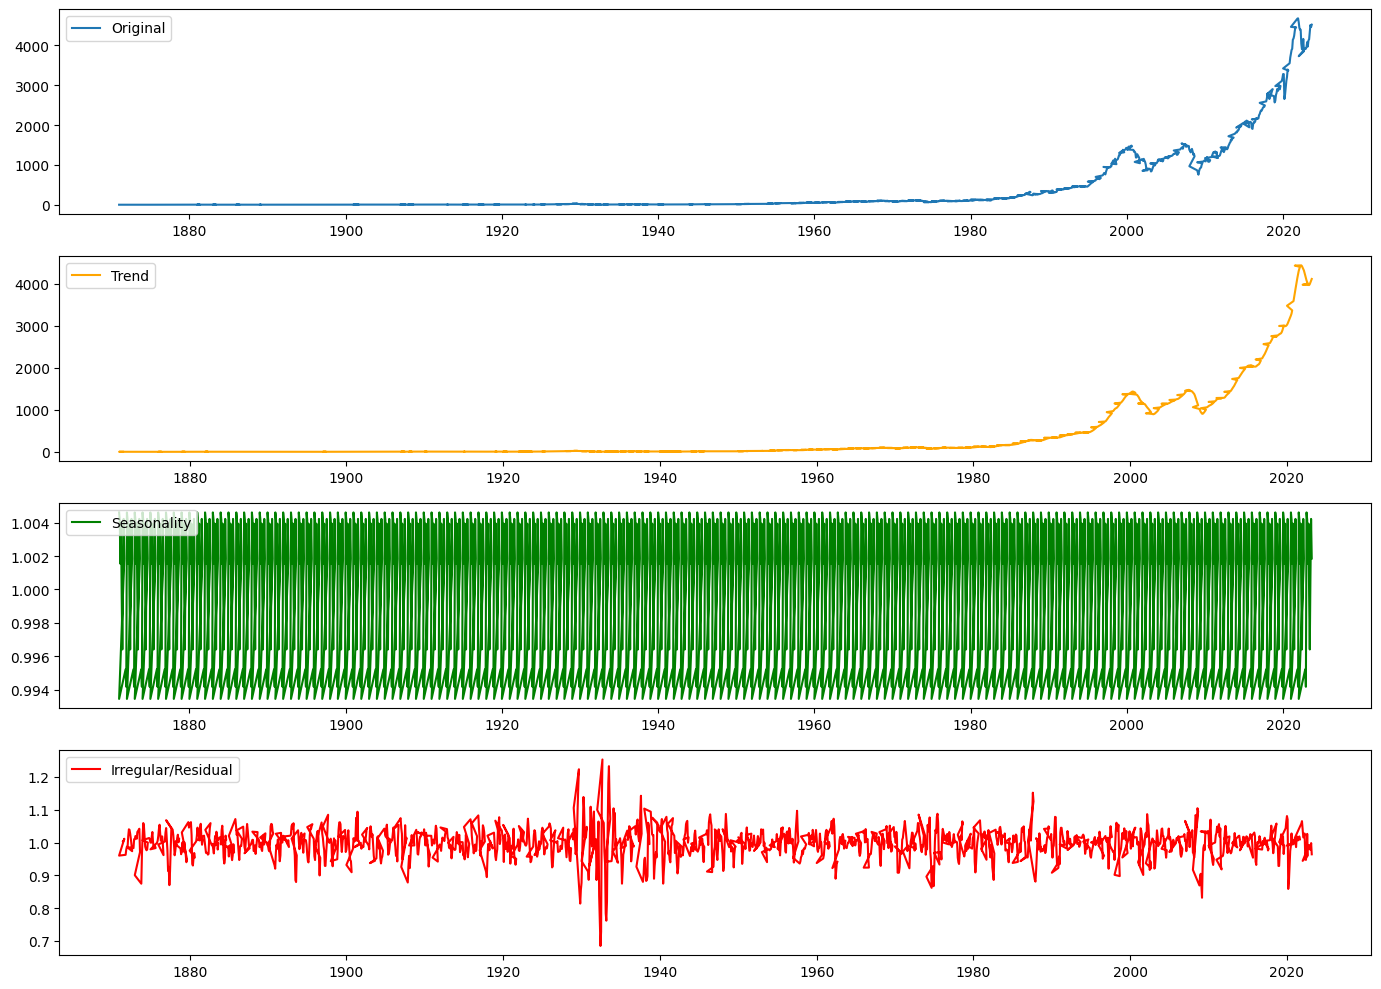

In [41]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series (use model='additive' or 'multiplicative' as appropriate)
decomposition = seasonal_decompose(time_series, model='multiplicative', period=12)

# Plot the components
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(time_series, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Irregular/Residual', color='red')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Statistical Tests of Stationarity

Visual inspection can be subjective. Therefore, we use statistical tests to check for stationarity. One of the most commonly used tests is the **Augmented Dickey-Fuller (ADF) test**.

The ADF test is a statistical test that tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is that the time series is stationary.

* **Null Hypothesis (H0):** The time series is non-stationary.
* **Alternative Hypothesis (H1):** The time series is stationary.

We interpret the result of the ADF test using the p-value. If the p-value is less than a significance level (e.g., 0.05), we reject the null hypothesis and conclude that the time series is stationary.

In [28]:
def adf_test(series):
    """Perform Augmented Dickey-Fuller test"""
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')

adf_test(time_series)

ADF Statistic: 8.18423822628802
p-value: 1.0
Critial Values:
   1%, -3.433968010099092
Critial Values:
   5%, -2.8631381499714745
Critial Values:
   10%, -2.567620802173316


If the p-value is greater than 0.05, we fail to reject the null hypothesis and conclude that the time series is non-stationary. In this case, we need to make the series stationary. A common way to do this is by **differencing** the series.

### Data Transformation (Stationarizing Techniques)

#### Differencing: Taking first differences `(X(t) - X(t-1))`

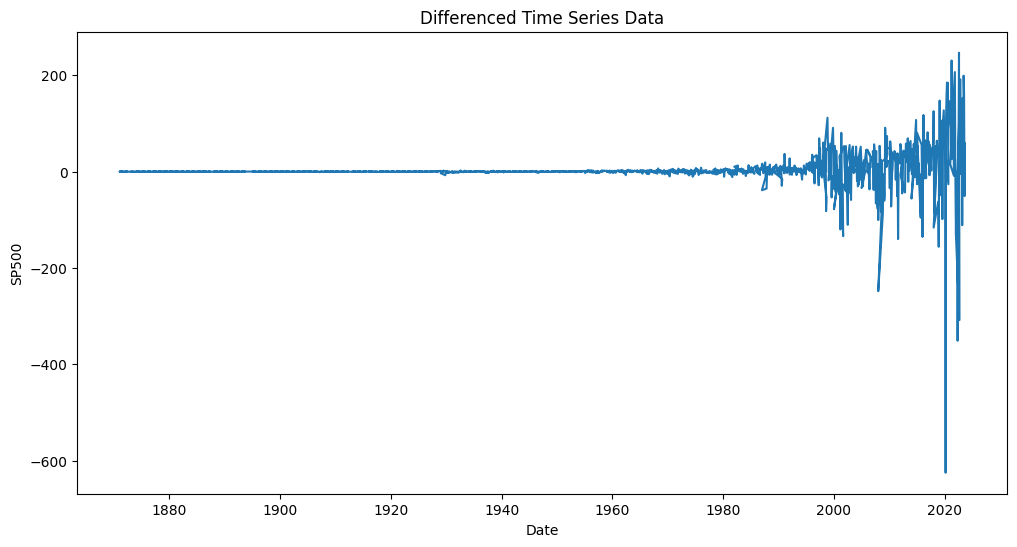

ADF Statistic: -6.339162201292332
p-value: 2.7822123486926007e-08
Critial Values:
   1%, -3.433976034843506
Critial Values:
   5%, -2.8631416925158244
Critial Values:
   10%, -2.5676226884667694


In [29]:
# If the series is non-stationary, we can difference it
time_series_diff = time_series.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(time_series_diff)
plt.title('Differenced Time Series Data')
plt.xlabel('Date')
plt.ylabel('SP500')
plt.show()

# Perform ADF test on the differenced series
adf_test(time_series_diff)

#### Detrending: Removing trend components

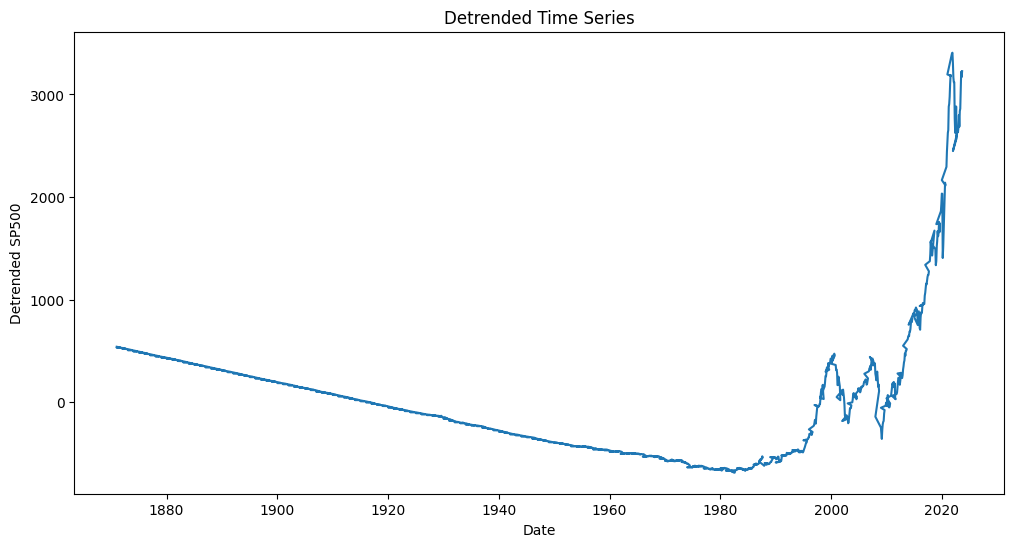

ADF Statistic: 4.23824583395975
p-value: 1.0
Critial Values:
   1%, -3.433972018026501
Critial Values:
   5%, -2.8631399192826676
Critial Values:
   10%, -2.5676217442756872


In [30]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Prepare the time index as a feature for regression
time_index = np.arange(len(time_series)).reshape(-1, 1)

# Fit linear regression (trend)
lr = LinearRegression()
lr.fit(time_index, time_series.values)
trend = lr.predict(time_index)

# Detrend the series
detrended_series = time_series.values - trend

# Plot the detrended series
plt.figure(figsize=(12, 6))
plt.plot(time_series.index, detrended_series)
plt.title('Detrended Time Series')
plt.xlabel('Date')
plt.ylabel('Detrended SP500')
plt.show()

adf_test(detrended_series)

#### Log transformation: For changing variance

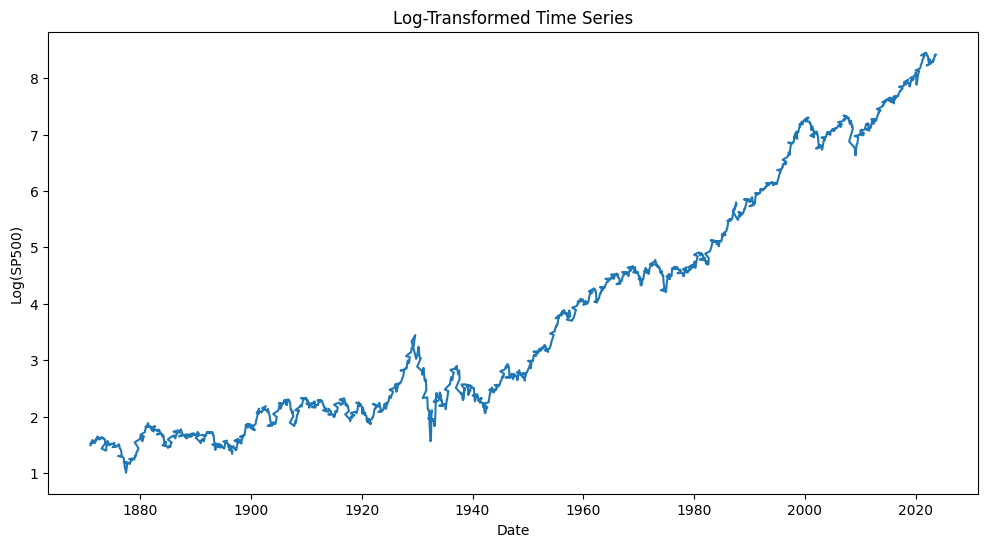

ADF Statistic: 1.4734995686648442
p-value: 0.997423748247072
Critial Values:
   1%, -3.433966009459769
Critial Values:
   5%, -2.8631372667825503
Critial Values:
   10%, -2.567620331903232


In [31]:
import numpy as np

# Apply log transformation (add a small constant if data contains zeros)
log_time_series = np.log(time_series + 1e-8)

# Plot the log-transformed series
plt.figure(figsize=(12, 6))
plt.plot(time_series.index, log_time_series)
plt.title('Log-Transformed Time Series')
plt.xlabel('Date')
plt.ylabel('Log(SP500)')
plt.show()

adf_test(log_time_series)

#### Seasonal differencing: For seasonal patterns

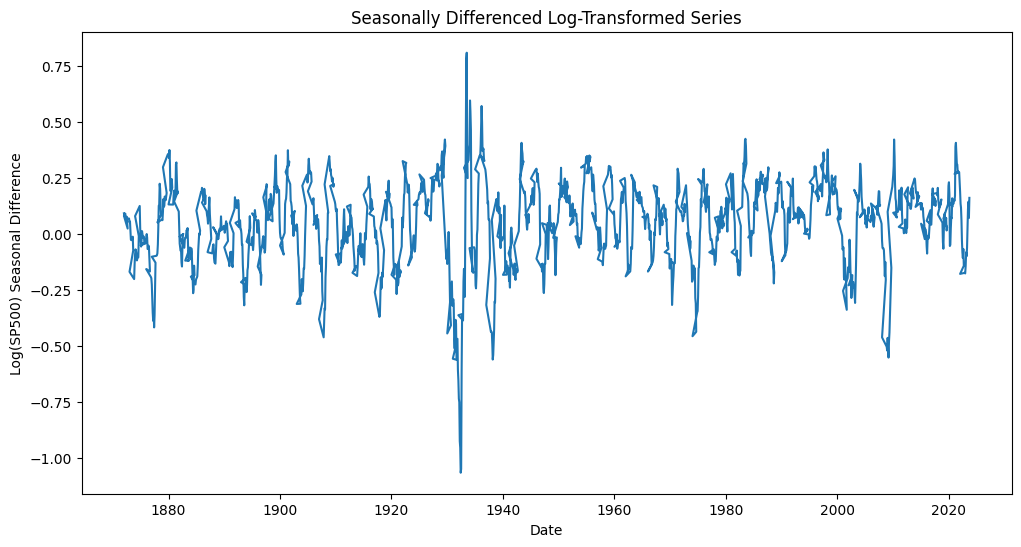

ADF Statistic: -6.551378800849234
p-value: 8.833521652807542e-09
Critial Values:
   1%, -3.4339982875683357
Critial Values:
   5%, -2.863151515989605
Critial Values:
   10%, -2.567627919165742


In [32]:
# Seasonal differencing (e.g., period=12 for monthly data)
seasonal_diff_log = log_time_series.diff(12).dropna()

plt.figure(figsize=(12, 6))
plt.plot(seasonal_diff_log)
plt.title('Seasonally Differenced Log-Transformed Series')
plt.xlabel('Date')
plt.ylabel('Log(SP500) Seasonal Difference')
plt.show()

adf_test(seasonal_diff_log)

### In-Built Stationarizing Mechanism in Models
1. **❌Exponential Smoothing (Simple, Double [Holt], and Triple [Holt-Winters])**
- Exponential Smoothing techniques do not require the series to be stationary.
- Instead, they explicitly model components such as trend and seasonality directly.
- They handle non-stationarity by design, rather than transforming the data to a stationary form.

2. **✅ARIMA (AutoRegressive Integrated Moving Average)**
- ARIMA explicitly includes differencing (the "I" in ARIMA) as part of the model to make the series stationary.
- You specify the `d` parameter in `ARIMA(p, d, q)`, where:
  - `d = 1` tells the model to difference the data once. This step transforms a non-stationary series into a stationary one internally.

3. **✅SARIMA (Seasonal ARIMA)**
- SARIMA extends ARIMA with seasonal differencing.
- It uses two differencing parameters:
  - `d` for non-seasonal differencing,
  - `D` for seasonal differencing over a defined period m.
- Therefore, SARIMA also has built-in mechanisms to induce both stationarity and seasonal stationarity.

4. **❌LSTM (Long Short-Term Memory Networks)**
- LSTM models do not have explicit stationarizing mechanisms.
- They learn directly from raw sequences, even if they are non-stationary.
- However, data preprocessing such as normalization and differencing often improves performance.
- LSTMs can model complex non-linear and non-stationary behavior, but they do not automatically make the data stationary.

## 2. Time Series Forecasting Techniques

### Exponential Smoothing

Exponential smoothing is a time series forecasting method for univariate data. It is a weighted average of past observations, with the weights decaying exponentially as the observations get older.

**Note:** Unlike ARIMA models, some exponential smoothing models are designed to handle non-stationary data directly by explicitly modeling trend and seasonality. This is why we can apply them to the original time series.

#### Simple Exponential Smoothing (SES)

SES is suitable for time series data with no trend or seasonality.

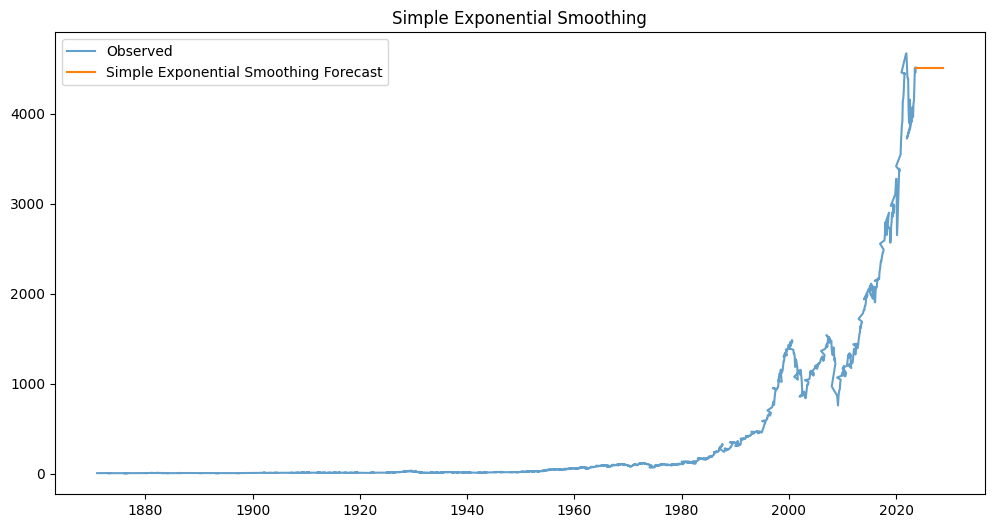

In [56]:
model_ses = SimpleExpSmoothing(time_series, initialization_method="estimated").fit()
predictions_ses = model_ses.forecast(60) # forecast for next 60 months

future_index = pd.date_range(
    start=time_series.index[-1] + pd.offsets.MonthEnd(1),
    periods=60,
    freq='M')
predictions_ses = pd.Series(predictions_ses.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Observed', alpha=0.7)
plt.plot(predictions_ses, label='Simple Exponential Smoothing Forecast')
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show()

#### Double Exponential Smoothing (Holt's Method)

Holt's method is an extension of SES that can handle time series data with a trend.

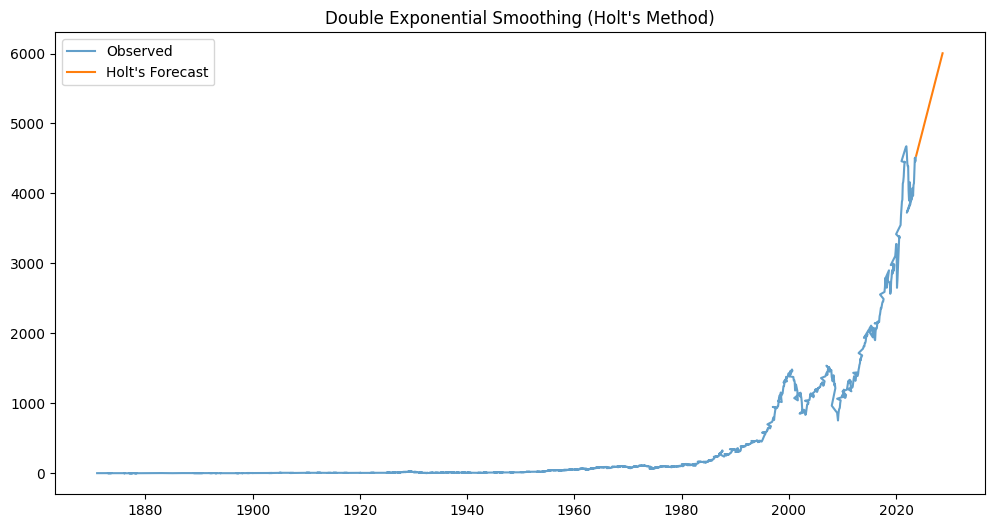

In [52]:
model_holt = Holt(time_series, initialization_method="estimated").fit()
predictions_holt = model_holt.forecast(60)

future_index = pd.date_range(
    start=time_series.index[-1] + pd.offsets.MonthEnd(1),
    periods=60,
    freq='M')
predictions_holt = pd.Series(predictions_holt.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Observed', alpha=0.7)
plt.plot(predictions_holt, label='Holt\'s Forecast')
plt.title('Double Exponential Smoothing (Holt\'s Method)')
plt.legend()
plt.show()

#### Triple Exponential Smoothing (Holt-Winters Method)

The Holt-Winters method extends Holt's method to capture seasonality.

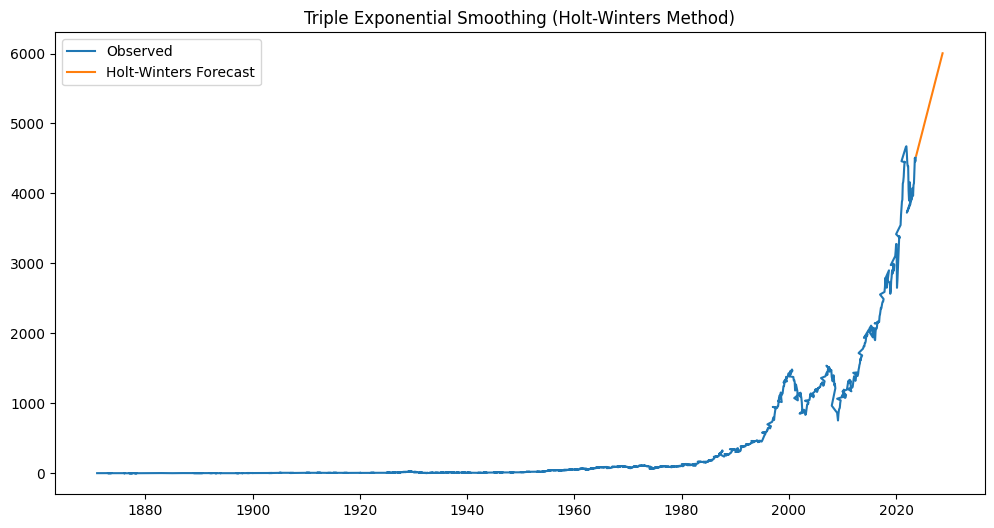

In [55]:
# Assuming a seasonal period of 12 for monthly data. Change if your data has a different seasonal period.
model_hw = ExponentialSmoothing(time_series, seasonal_periods=12, trend='add', seasonal='add', initialization_method="estimated").fit()
predictions_hw = model_hw.forecast(60)

future_index = pd.date_range(
    start=time_series.index[-1] + pd.offsets.MonthEnd(1),
    periods=60,
    freq='M')
predictions_hw = pd.Series(predictions_holt.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Observed')
plt.plot(predictions_hw, label='Holt-Winters Forecast')
plt.title('Triple Exponential Smoothing (Holt-Winters Method)')
plt.legend()
plt.show()

### ARIMA

ARIMA stands for AutoRegressive Integrated Moving Average. It is a class of models that explains a given time series based on its own past values, that is, its own lags and the lagged forecast errors.

An ARIMA model is characterized by 3 parameters: (p, d, q).

* **p:** The number of lag observations included in the model (lag order).
* **d:** The number of times that the raw observations are differenced (degree of differencing).
* **q:** The size of the moving average window (order of moving average).

**Important Note:** You might wonder why we are using the original `time_series` which is non-stationary. The `statsmodels` implementation of ARIMA is smart. The `d` parameter in the `order=(p,d,q)` argument tells the model how many times to difference the data. So, the model takes care of the differencing internally. This is the standard and recommended way to use ARIMA models in `statsmodels`, as it simplifies the process and automatically returns the forecasts on the original scale.

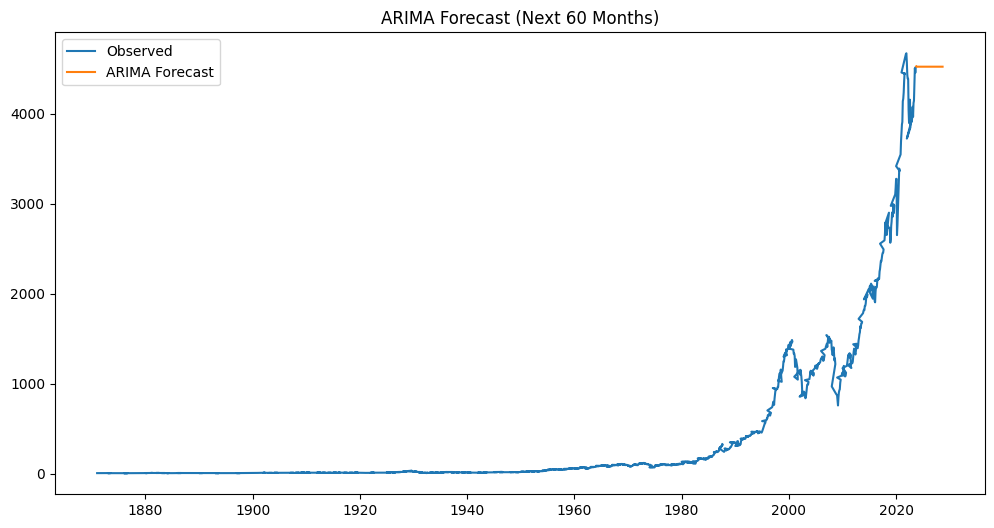

In [57]:
# Forecast the next 60 months using ARIMA
model_arima = ARIMA(time_series, order=(1, 1, 1)).fit()
predictions_arima = model_arima.forecast(steps=60)

# Create a future index for the next 60 months
future_index = pd.date_range(
    start=time_series.index[-1] + pd.offsets.MonthEnd(1),
    periods=60,
    freq='M'
)
predictions_arima = pd.Series(predictions_arima.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Observed')
plt.plot(predictions_arima, label='ARIMA Forecast')
plt.title('ARIMA Forecast (Next 60 Months)')
plt.legend()
plt.show()

### SARIMA

SARIMA (Seasonal ARIMA) is an extension of ARIMA that supports time series data with a seasonal component.

A SARIMA model is characterized by 7 parameters: (p, d, q) x (P, D, Q, m).

* **(p, d, q):** The non-seasonal parameters of the ARIMA model.
* **(P, D, Q, m):** The seasonal parameters of the model, where 'm' is the number of time steps for a single seasonal period.

Just like with ARIMA, we use the original time series here and let the model handle the differencing (both seasonal and non-seasonal) for us via the `d` and `D` parameters.

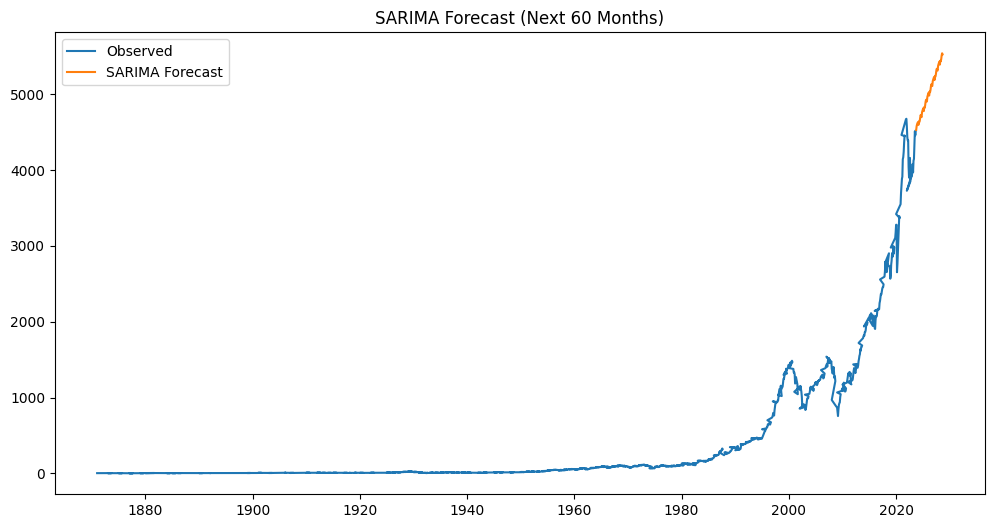

In [58]:
# Forecast the next 60 months using SARIMA
model_sarima = SARIMAX(time_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
predictions_sarima = model_sarima.forecast(steps=60)

# Create a future index for the next 60 months
future_index = pd.date_range(
    start=time_series.index[-1] + pd.offsets.MonthEnd(1),
    periods=60,
    freq='M'
)
predictions_sarima = pd.Series(predictions_sarima.values, index=future_index)

plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Observed')
plt.plot(predictions_sarima, label='SARIMA Forecast')
plt.title('SARIMA Forecast (Next 60 Months)')
plt.legend()
plt.show()

### LSTM Neural Network
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) capable of learning long-term dependencies in sequence data. They are well suited for time series forecasting tasks because they can capture both short- and long-term temporal patterns.

**Stationarity Requirement:** LSTM models do not strictly require the data to be stationary because they learn patterns directly from the raw sequences. However, it is recommended to scale the data and to remove strong trends or seasonality (for example, via differencing or decomposition) to improve convergence and predictive performance.

In [38]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(time_series.values.reshape(-1, 1))

def create_sequences(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

window_size = 12
X, y = create_sequences(scaled_series, window_size)
train_size = len(X) - 12
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model_lstm = Sequential([
    LSTM(50, activation='tanh', input_shape=(window_size, 1)),
    Dense(1)
])
model_lstm.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

# Forecast the next 60 months
last_sequence = scaled_series[-window_size:].reshape(1, window_size, 1)
future_predictions_scaled = []
for _ in range(60):
    next_pred = model_lstm.predict(last_sequence, verbose=0)
    future_predictions_scaled.append(next_pred[0, 0])
    last_sequence = np.append(last_sequence[:, 1:, :], [[next_pred]], axis=1)

future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1)).flatten()

# Create future index for the next 60 months
future_index = pd.date_range(
    start=time_series.index[-1] + pd.offsets.MonthEnd(1),
    periods=60,
    freq='M'
)

plt.figure(figsize=(12, 6))
plt.plot(time_series, label='Observed')
plt.plot(future_index, future_predictions, label='LSTM Forecast (Next 60 Months)')
plt.title('LSTM Forecast (Next 60 Months)')
plt.legend()
plt.show()

ModuleNotFoundError: No module named 'tensorflow'

## 3. Model Comparison

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Safe MAPE function
def safe_mape(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# True values for comparison
true_values = time_series[-12:]

# Ensure predictions are properly aligned
forecasts = {
    'SES': predictions_ses[:12],
    'Holt': predictions_holt[:12],
    'Holt-Winters': predictions_hw[:12],
    'ARIMA': predictions_arima[:12],
    'SARIMA': predictions_sarima[:12],
    'LSTM': pd.Series(predictions_lstm.flatten(), index=true_values.index)[:12]
}

# Compute metrics
metrics = []
for model_name, pred in forecasts.items():
    mae = mean_absolute_error(true_values, pred)
    rmse = np.sqrt(mean_squared_error(true_values, pred))
    mape = safe_mape(true_values.values, pred.values)
    metrics.append({'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'MAPE': mape})

# Create DataFrame
metrics_df = pd.DataFrame(metrics).set_index('Model')
print("Model Performance Comparison:")
print(metrics_df.round(2))

# Plot metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics_df['MAE'].plot(kind='bar', ax=axes[0], title='MAE (Lower is Better)', color='skyblue')
metrics_df['RMSE'].plot(kind='bar', ax=axes[1], title='RMSE (Lower is Better)', color='lightgreen')
metrics_df['MAPE'].plot(kind='bar', ax=axes[2], title='MAPE % (Lower is Better)', color='salmon')

for ax in axes:
    ax.set_ylabel('')
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


## 4. Saving Predictions

Finally, let's see how to view and save our predictions to a CSV file.

In [ ]:
print("SES Predictions:")
print(predictions_ses)

print("\nHolt's Predictions:")
print(predictions_holt)

print("\nHolt-Winters Predictions:")
print(predictions_hw)

print("\nARIMA Predictions:")
print(predictions_arima)

print("\nSARIMA Predictions:")
print(predictions_sarima)

print("\nLSTM Predictions:")
# Convert predictions_lstm to Series with the same index as the last 12 true values
lstm_series = pd.Series(predictions_lstm.flatten(), index=predictions_ses.index)
print(lstm_series)

# Save predictions to a CSV file
predictions_df = pd.DataFrame({
    'SES': predictions_ses,
    'Holt': predictions_holt,
    'Holt-Winters': predictions_hw,
    'ARIMA': predictions_arima,
    'SARIMA': predictions_sarima,
    'LSTM': lstm_series
})

display(predictions_df)

# predictions_df.to_csv('./data/SP500Index_predictions.csv')